In [8]:
from urllib.parse import urlencode
from urllib.request import urlopen
import pickle
import json
from collections import OrderedDict
import numpy as np
import os




class SubmissionBase:

    submit_url = 'https://www-origin.coursera.org/api/' \
                 'onDemandProgrammingImmediateFormSubmissions.v1'
    save_file = 'token.pkl'

    def __init__(self, assignment_slug, part_names):
        self.assignment_slug = assignment_slug
        self.part_names = part_names
        self.login = None
        self.token = None
        self.functions = OrderedDict()
        self.args = dict()

    def grade(self):
        print('\nSubmitting Solutions | Programming Exercise %s\n' % self.assignment_slug)
        self.login_prompt()

        # Evaluate the different parts of exercise
        parts = OrderedDict()
        for part_id, result in self:
            parts[str(part_id)] = {'output': sprintf('%0.5f ', result)}
        result, response = self.request(parts)
        response = json.loads(response)

        # if an error was returned, print it and stop
        if 'errorMessage' in response:
            print(response['errorMessage'])
            return

        # Print the grading table
        print('%43s | %9s | %-s' % ('Part Name', 'Score', 'Feedback'))
        print('%43s | %9s | %-s' % ('---------', '-----', '--------'))
        for part in parts:
            part_feedback = response['partFeedbacks'][part]
            part_evaluation = response['partEvaluations'][part]
            score = '%d / %3d' % (part_evaluation['score'], part_evaluation['maxScore'])
            print('%43s | %9s | %-s' % (self.part_names[int(part) - 1], score, part_feedback))
        evaluation = response['evaluation']
        total_score = '%d / %d' % (evaluation['score'], evaluation['maxScore'])
        print('                                  --------------------------------')
        print('%43s | %9s | %-s\n' % (' ', total_score, ' '))

    def login_prompt(self):
        if os.path.isfile(self.save_file):
            with open(self.save_file, 'rb') as f:
                login, token = pickle.load(f)
            reenter = input('Use token from last successful submission (%s)? (Y/n): ' % login)

            if reenter == '' or reenter[0] == 'Y' or reenter[0] == 'y':
                self.login, self.token = login, token
                return
            else:
                os.remove(self.save_file)

        self.login = input('Login (email address): ')
        self.token = input('Token: ')

        # Save the entered credentials
        if not os.path.isfile(self.save_file):
            with open(self.save_file, 'wb') as f:
                pickle.dump((self.login, self.token), f)

    def request(self, parts):
        params = {
            'assignmentSlug': self.assignment_slug,
            'secret': self.token,
            'parts': parts,
            'submitterEmail': self.login}

        params = urlencode({'jsonBody': json.dumps(params)}).encode("utf-8")
        f = urlopen(self.submit_url, params)
        try:
            return 0, f.read()
        finally:
            f.close()

    def __iter__(self):
        for part_id in self.functions:
            yield part_id

    def __setitem__(self, key, value):
        self.functions[key] = value


def sprintf(fmt, arg):
    """ Emulates (part of) Octave sprintf function. """
    if isinstance(arg, tuple):
        # for multiple return values, only use the first one
        arg = arg[0]

    if isinstance(arg, (np.ndarray, list)):
        # concatenates all elements, column by column
        return ' '.join(fmt % e for e in np.asarray(arg).ravel('F'))
    else:
        return fmt % arg
    
import numpy as np
import sys
sys.path.append('..')



class Grader(SubmissionBase):
    X1 = np.column_stack((np.ones(20), np.exp(1) + np.exp(2) * np.linspace(0.1, 2, 20)))
    Y1 = X1[:, 1] + np.sin(X1[:, 0]) + np.cos(X1[:, 1])
    X2 = np.column_stack((X1, X1[:, 1]**0.5, X1[:, 1]**0.25))
    Y2 = np.power(Y1, 0.5) + Y1

    def __init__(self):
        part_names = ['Warm up exercise',
                      'Computing Cost (for one variable)',
                      'Gradient Descent (for one variable)',
                      'Feature Normalization',
                      'Computing Cost (for multiple variables)',
                      'Gradient Descent (for multiple variables)',
                      'Normal Equations']
        super().__init__('linear-regression', part_names)

    def __iter__(self):
        for part_id in range(1, 8):
            try:
                func = self.functions[part_id]

                # Each part has different expected arguments/different function
                if part_id == 1:
                    res = func()
                elif part_id == 2:
                    res = func(self.X1, self.Y1, np.array([0.5, -0.5]))
                elif part_id == 3:
                    res = func(self.X1, self.Y1, np.array([0.5, -0.5]), 0.01, 10)
                elif part_id == 4:
                    res = func(self.X2[:, 1:4])
                elif part_id == 5:
                    res = func(self.X2, self.Y2, np.array([0.1, 0.2, 0.3, 0.4]))
                elif part_id == 6:
                    res = func(self.X2, self.Y2, np.array([-0.1, -0.2, -0.3, -0.4]), 0.01, 10)
                elif part_id == 7:
                    res = func(self.X2, self.Y2)
                else:
                    raise KeyError
                yield part_id, res
            except KeyError:
                yield part_id, 0

In [9]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# library written for this exercise providing additional functions for assignment submission, and others


# define the submission/grader object for this exercise
grader = Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [10]:
A = np.eye(5)

In [11]:

def warmUpExercise():
    """
    Example function in Python which computes the identity matrix.
    
    Returns
    -------
    A : array_like
        The 5x5 identity matrix.
    
    Instructions
    ------------
    Return the 5x5 identity matrix.
    """    
    # ======== YOUR CODE HERE ======
    A = np.eye(5)  # modify this line
    
    # ==============================
    return A

In [12]:
warmUpExercise()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [43]:
#Part 2 Linear Regression with One Variable
data = np.loadtxt(os.path.join('Data', 'ex1data1.txt'), delimiter=',')
x, y = data[:, 0], data[:, 1]
m = y.size  # number of training examples
y

array([17.592  ,  9.1302 , 13.662  , 11.854  ,  6.8233 , 11.886  ,
        4.3483 , 12.     ,  6.5987 ,  3.8166 ,  3.2522 , 15.505  ,
        3.1551 ,  7.2258 ,  0.71618,  3.5129 ,  5.3048 ,  0.56077,
        3.6518 ,  5.3893 ,  3.1386 , 21.767  ,  4.263  ,  5.1875 ,
        3.0825 , 22.638  , 13.501  ,  7.0467 , 14.692  , 24.147  ,
       -1.22   ,  5.9966 , 12.134  ,  1.8495 ,  6.5426 ,  4.5623 ,
        4.1164 ,  3.3928 , 10.117  ,  5.4974 ,  0.55657,  3.9115 ,
        5.3854 ,  2.4406 ,  6.7318 ,  1.0463 ,  5.1337 ,  1.844  ,
        8.0043 ,  1.0179 ,  6.7504 ,  1.8396 ,  4.2885 ,  4.9981 ,
        1.4233 , -1.4211 ,  2.4756 ,  4.6042 ,  3.9624 ,  5.4141 ,
        5.1694 , -0.74279, 17.929  , 12.054  , 17.054  ,  4.8852 ,
        5.7442 ,  7.7754 ,  1.0173 , 20.992  ,  6.6799 ,  4.0259 ,
        1.2784 ,  3.3411 , -2.6807 ,  0.29678,  3.8845 ,  5.7014 ,
        6.7526 ,  2.0576 ,  0.47953,  0.20421,  0.67861,  7.5435 ,
        5.3436 ,  4.2415 ,  6.7981 ,  0.92695,  0.152  ,  2.82

In [44]:
def plotData(x,y):
    fig = pyplot.figure()
    pyplot.plot(x,y,'ro',ms=10,mec='k') #Plots X vs. Y
    pyplot.ylabel('profit in $10,000')
    pyplot.xlabel('Population of City')


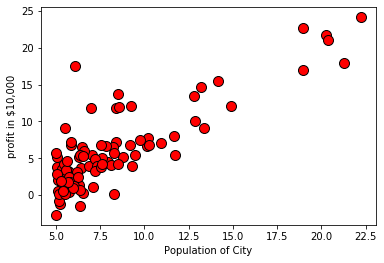

In [45]:
plotData(x,y)

In [46]:
#Gradient Descent
#We have to add another dimension to the data. We add theta(0) 
#To add another column to an array/data table:
x = np.stack([np.ones(m), x], axis=1)


In [96]:
def computeCost(x, y, theta):
    """
    Compute cost for linear regression. Computes the cost of using theta as the
    parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1), where m is the number of examples,
        and n is the number of features. We assume a vector of one's already 
        appended to the features so we have n+1 columns.
    
    y : array_like
        The values of the function at each data point. This is a vector of
        shape (m, ).
    
    theta : array_like
        The parameters for the regression function. This is a vector of 
        shape (n+1, ).
    
    Returns
    -------
    J : float
        The value of the regression cost function.
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. 
    You should set J to the cost.
    """
    
    # initialize some useful values
    m = y.size  # number of training examples
    
    # You need to return the following variables correctly
    J = 0
    
    # ====================== YOUR CODE HERE =====================
    #dot != dot product
    #We dot all the cells in x and theta 
    h = np.dot(x,theta)
    J = (1/(2*m))*np.sum(np.square(h-y))
    
    # ===========================================================
  
    return J
#Why I was wrong the first time: When you do
# J = (h-y[i]) * (h-y[i])
# J += J
#The dot product for each row can actually end up being 0*0 + 0*0
# SO all you do is add 0 to itself when h is 0.
#However, my code is hard coded for only theta.size == 2
#Turn it into the general form

In [97]:
J = computeCost(x, y, theta=np.array([0.0, 0.0]))
print('With theta = [0, 0] \nCost computed = %.2f' % J)
print('Expected cost value (approximately) 32.07\n')

With theta = [0, 0] 
Cost computed = 32.07
Expected cost value (approximately) 32.07



In [98]:
grader[2] = computeCost
grader.grade()


Submitting Solutions | Programming Exercise linear-regression

Use token from last successful submission (canngo215@gmail.com)? (Y/n): Y
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                           Warm up exercise |  10 /  10 | Nice work!
          Computing Cost (for one variable) |  40 /  40 | Nice work!
        Gradient Descent (for one variable) |   0 /  50 | 
                      Feature Normalization |   0 /   0 | 
    Computing Cost (for multiple variables) |   0 /   0 | 
  Gradient Descent (for multiple variables) |   0 /   0 | 
                           Normal Equations |   0 /   0 | 
                                  --------------------------------
                                            |  50 / 100 |  



In [ ]:
def gradientDescent(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn `theta`. Updates theta by taking `num_iters`
    gradient steps with learning rate `alpha`.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1).
    
    y : arra_like
        Value at given features. A vector of shape (m, ).
    
    theta : array_like
        Initial values for the linear regression parameters. 
        A vector of shape (n+1, ).
    
    alpha : float
        The learning rate.
    
    num_iters : int
        The number of iterations for gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    
    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of 
    the cost function (computeCost) and gradient here.
    """
    # Initialize some useful values
    m = y.shape[0]  # number of training examples
    
    # make a copy of theta, to avoid changing the original array, since numpy arrays
    # are passed by reference to functions
    theta = theta.copy()
    
    J_history = [] # Use a python list to save cost in every iteration
    
    for i in range(num_iters):
        # ==================== YOUR CODE HERE =================================
        h = np.dot(X,theta)
        theta =  theta - (alpha / m) * (h-y).dot(X)

        # =====================================================================
        
        # save the cost J in every iteration
        J_history.append(computeCost(X, y, theta))
    
    return theta, J_history

In [ ]:
# initialize fitting parameters
theta = np.zeros(2)

# some gradient descent settings
iterations = 1500
alpha = 0.01

theta, J_history = gradientDescent(x ,y, theta, alpha, iterations)
print('Theta found by gradient descent: {:.4f}, {:.4f}'.format(*theta))
print('Expected theta values (approximately): [-3.6303, 1.1664]')

In [ ]:
# plot the linear fit
plotData(X[:, 1], y)
pyplot.plot(X[:, 1], np.dot(X, theta), '-')
pyplot.legend(['Training data', 'Linear regression']);

In [ ]:
# Predict values for population sizes of 35,000 and 70,000
predict1 = np.dot([1, 3.5], theta)
print('For population = 35,000, we predict a profit of {:.2f}\n'.format(predict1*10000))

predict2 = np.dot([1, 7], theta)
print('For population = 70,000, we predict a profit of {:.2f}\n'.format(predict2*10000))

In [ ]:
grader[3] = gradientDescent
grader.grade()

In [2]:
import numpy as np
a = np.array([1,2,3,4])
x = np.array([[1,2],
             [1,2],
             [1,2],
             [1,2]
             ])
print(a.dot(x))

[10 20]
